# 深度学习入门(day1) - 线性回归
## 线性回归的数学原理
线性回归基于几个简单的假设：首先，假设自变量 $x$ 和因变量 $y$ 之间的关系是线性的，即 $y$ 可以表示为 $x$ 中元素的加权和，这里通常允许包含观测值的一些噪声；其次，我们假设任何噪声都比较正常，如噪声遵循正态分布。

有一组数据 
$$\mathbf{X} = 
\begin{bmatrix}
x_{11} & x_{12} & \cdots & x_{1n} \\
x_{21} & x_{22} & \cdots & x_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{d1} & x_{d2} & \cdots & x_{dn}
\end{bmatrix}$$
和 
$$y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$$
要如何找到一条由 $w = [w_1, w_2, w_3, \dots, w_n]$ 和 $b$ 确定的曲线 $\hat{y}=wx^T+b$，使得 $\hat{y}$ 尽可能的接近 $y$?

1. 如何表示预测值 $\hat{y}$ 与真实值 $y$ 的接近程度？

    使用均方损失 $\mathrm{\ell}(X, y, w, b)=\frac{1}{2}\cdot\frac{1}{n}\sum\limits_{i=1}^{n}{(y_i-\hat{y_i})^2}=\frac{1}{2}\cdot\frac{1}{n}\sum\limits_{i=1}^{n}{(y_i-\langle w, x_i \rangle - b)^2}=\frac{1}{2n}||y-(Xw+b)||^2$ ，用 $\frac{1}{2}$ 抵消求导后的系数简化计算。

2. 如何根据损失更新 $w$ 和 $b$？

    对于给定的 $X, y$，求出一组 $w^*, b^*$ 使得 $\mathrm{\ell}(X, y, w, b)$ 取得最小值：$w^*, b^*=\underset{w, b}{\arg\max}{\mathrm{\ell}(X, y, w, b)}$。对于一些函数可以用偏导数为0解出极值点，但是大多数情况无解，所以要用到梯度下降算法： $$ w_{k+1} = w_{k} - \alpha\frac{\partial \ell}{\partial w}  $$ 将偏差b加入到权重简化计算：$X \leftarrow \begin{bmatrix} X \\ 1 \end{bmatrix}$，$w \leftarrow \begin{bmatrix} w \\ b \end{bmatrix}$


## 线性回归代码实现

### 准备训练数据
首先导入包

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
import torch

生成训练数据集

In [11]:
# 生成配置参数
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2.4, -2.1])
true_b = 4.1
features, labels = synthetic_data(true_w, true_b, 1000)

可视化特征与目标值的关系

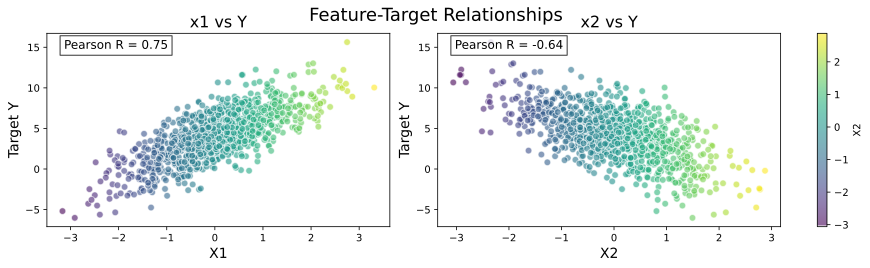

In [ ]:
df = pd.DataFrame(features, columns=[f'x{i+1}' for i in range(len(true_w))])
df['y'] = labels

import matplotlib.pyplot as plt

def show_scatter(df):
    features = df.columns[0:-1]  # 获取所有特征列名

    # 创建组合画布（宽度增大适应横向布局）
    fig, axes = plt.subplots(
        nrows=1,  # 单行布局
        ncols=len(features),  # 列数等于特征数量
        figsize=(6 * len(features), 3.5),  # 动态宽度适配特征数量
        dpi=100,
        constrained_layout=True  # 自动调整子图间距
    )

    # 并行循环特征与对应的坐标轴
    for ax, feature in zip(axes, features):
        # 在指定坐标轴上绘制散点图
        sc = ax.scatter(
            df[feature], df['y'], 
            alpha=0.6,
            edgecolor='w',
            s=45, 
            c=df[feature],
            cmap='viridis'
        )
        
        # 添加颜色条（共享同一刻度）
        if ax == axes[-1]:  # 只在最后一个坐标轴添加颜色条
            plt.colorbar(sc, ax=axes, label=feature.upper())
        
        # 添加统计信息
        corr = df[feature].corr(df['y'])
        ax.text(
            0.05, 0.92, 
            f'Pearson R = {corr:.2f}',
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )
        
        # 设置坐标标签
        ax.set_xlabel(feature.upper(), fontsize=14)
        ax.set_ylabel('Target Y', fontsize=14)
        ax.set_title(f'{feature} vs Y', fontsize=16)

    # 调整整体标题（可选）
    fig.suptitle('Feature-Target Relationships', fontsize=18, y=1.02)
    plt.show()
    
show_scatter(df)

小批量读取数据集

In [13]:
import random
import torch

def data_iter(batch_size, features, labels):
    if len(features) != len(labels):
        print("len(features) != len(labels)")
        raise IndexError
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

### 定义模型

初始化模型参数w ,b

In [14]:
# w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 长度为2的列向量
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义线性回归模型

In [15]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 定义损失函数 
$\mathrm{\ell}(X, y, w, b)=\frac{1}{2}\cdot\frac{1}{n}\sum\limits_{i=1}^{n}{(y_i-\hat{y_i})^2}$ 

In [16]:
def squared_loss(y_hat, y):
    if len(y) != len(y_hat):
        print("len(y) != len(y_hat)")
        raise ValueError
    return ((y_hat - y.reshape(y_hat.shape)) ** 2).mean() / 2

### 定义梯度下降算法

In [17]:
def sgd(params, lr):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

### 开始训练

In [18]:
batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.029633
epoch 2, loss 0.000117
epoch 3, loss 0.000049


In [19]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 3.9816e-05, -1.4021e-03], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


## 总结
学习了基础的线性回归模型，当加入更多参数时，根据参数的取值范围和相关性，线性回归无法解决问题，需进一步了解数据预处理以及梯度下降算法。